# Part 2: Differentiable Communication Systems

This tutorial will guide you through Sionna, from its basic principles to the implementation of a point-to-point link with a 5G NR compliant code and a 3GPP channel model.
You will also learn how to write custom trainable layers by implementing a state of the art neural receiver, and how to train and evaluate end-to-end communication systems.

The tutorial is structured in four notebooks:

- Part I: Getting started with Sionna

- **Part II: Differentiable Communication Systems**

- Part III: Advanced Link-level Simulations

- Part IV: Toward Learned Receivers

The [official documentation](https://nvlabs.github.io/sionna) provides key material on how to use Sionna and how its components are implemented.

* [Imports](#Imports)
* [Gradient Computation Through End-to-end Systems](#Gradient-Computation-Through-End-to-end-Systems)
* [Creating Custom Layers](#Creating-Custom-Layers)
* [Setting up Training Loops](#Setting-up-Training-Loops)

## Imports

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For saving complex Python data structures efficiently
import pickle

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer

# Set seed for reproducable results
sn.config.seed = 42

## Gradient Computation Through End-to-end Systems<a class="anchor" id="Gradient-Computation-Through-End-to-end-Systems"></a>

Let's start by setting up a simple communication system that transmit bits modulated as QAM symbols over an AWGN channel.

However, compared to what we have previously done, we now make the constellation *trainable*. With Sionna, achieving this requires only setting a boolean parameter to `True` when instantiating the ``Constellation`` object.

In [2]:
# Binary source to generate uniform i.i.d. bits
binary_source = sn.utils.BinarySource()

# 256-QAM constellation
NUM_BITS_PER_SYMBOL = 6
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # The constellation is set to be trainable

# Mapper and demapper
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN channel
awgn_channel = sn.channel.AWGN()

As we have already seen, we can now easily simulate forward passes through the system we have just setup

In [3]:
BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel
EBN0_DB = 17.0 # Eb/N0 in dB

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE,
                        1200]) # Blocklength
x = mapper(bits)
y = awgn_channel([x, no])
llr = demapper([y,no])

Just for fun, let's visualize the channel inputs and outputs

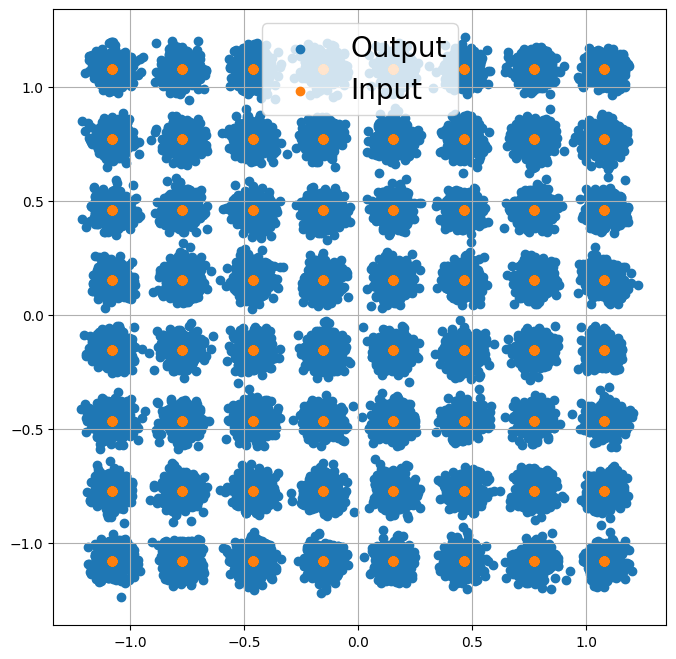

In [4]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label='Output')
plt.scatter(tf.math.real(x), tf.math.imag(x), label='Input')
plt.legend(fontsize=20);

Let's now *optimize* the constellation through *stochastic gradient descent* (SGD). As we will see, this is made very easy by Sionna.

We need to define a *loss function* that we will aim to minimize.

We can see the task of the receiver as jointly solving, for each received symbol, `NUM_BITS_PER_SYMBOL` binary classification problems in order to reconstruct the transmitted bits.
Therefore, a natural choice for the loss function is the *binary cross-entropy* (BCE) applied to each bit and to each received symbol.

*Remark:* The LLRs computed by the demapper are *logits* on the transmitted bits, and can therefore be used as-is to compute the BCE without any additional processing.
*Remark 2:* The BCE is closely related to an achieveable information rate for bit-interleaved coded modulation systems [1,2]

[1] Georg Böcherer, "Principles of Coded Modulation", [available online](http://www.georg-boecherer.de/bocherer2018principles.pdf)

[2] F. Ait Aoudia and J. Hoydis, "End-to-End Learning for OFDM: From Neural Receivers to Pilotless Communication," in IEEE Transactions on Wireless Communications, vol. 21, no. 2, pp. 1049-1063, Feb. 2022, doi: 10.1109/TWC.2021.3101364.

In [5]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

print(f"BCE: {bce(bits, llr)}")

BCE: 0.00012394240184221417


One iteration of SGD consists in three steps:
1. Perform a forward pass through the end-to-end system and compute the loss function
2. Compute the gradient of the loss function with respect to the trainable weights
3. Apply the gradient to the weights

To enable gradient computation, we need to perform the forward pass (step 1) within a `GradientTape`

In [6]:
with tf.GradientTape() as tape:
    bits = binary_source([BATCH_SIZE,
                            1200]) # Blocklength
    x = mapper(bits)
    y = awgn_channel([x, no])
    llr = demapper([y,no])
    loss = bce(bits, llr)

Using the ``GradientTape``, computing the gradient is done as follows

In [7]:
gradient = tape.gradient(loss, tape.watched_variables())

`gradient` is a list of tensors, each tensor corresponding to a trainable variable of our model.

For this model, we only have a single trainable tensor: The constellation of shape [`2`, `2^NUM_BITS_PER_SYMBOL`], the first dimension corresponding to the real and imaginary components of the constellation points.

*Remark:* It is important to notice that the gradient computation was performed *through the demapper and channel*, which are conventional non-trainable algorithms implemented as *differentiable* Keras layers. This key feature of Sionna enables the training of end-to-end communication systems that combine both trainable and conventional and/or non-trainable signal processing algorithms.

In [8]:
for g in gradient:
    print(g.shape)

(2, 64)


Applying the gradient (third step) is performed using an *optimizer*. [Many optimizers are available as part of TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), and we use in this notebook ``Adam``.

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-2)

Using the optimizer, the gradients can be applied to the trainable weights to update them

In [10]:
optimizer.apply_gradients(zip(gradient, tape.watched_variables()));

Let's compare the constellation before and after the gradient application

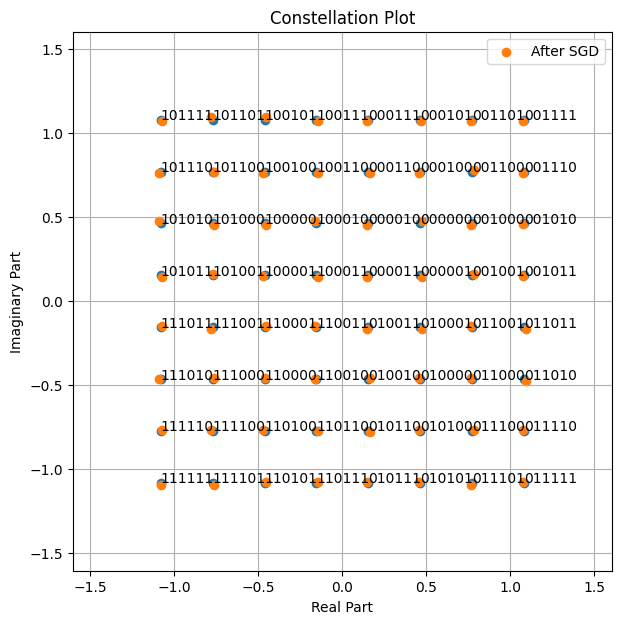

In [11]:
fig = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label='After SGD')
fig.axes[0].legend();

The SGD step has led to slight change in the position of the constellation points. Training of a communication system using SGD consists in looping over such SGD steps until a stop criterion is met.

## Creating Custom Layers<a class="anchor" id="Creating-Custom-Layers"></a>

Custom trainable (or not trainable) algorithms should be implemented as [Keras layers](https://keras.io/api/layers/). All Sionna components, such as the mapper, demapper, channel... are implemented as Keras layers.

To illustrate how this can be done, the next cell implements a simple neural network-based demapper which consists of three dense layers.

In [12]:
class NeuralDemapper(Layer): # Inherits from Keras Layer

    def __init__(self):
        super().__init__()

        # The three dense layers that form the custom trainable neural network-based demapper
        self.dense_1 = Dense(64, 'relu')
        self.dense_2 = Dense(64, 'relu')
        self.dense_3 = Dense(NUM_BITS_PER_SYMBOL, None) # The last layer has no activation and therefore outputs logits, i.e., LLRs

    def call(self, y):

        # y : complex-valued with shape [batch size, block length]
        # y is first mapped to a real-valued tensor with shape
        #  [batch size, block length, 2]
        # where the last dimension consists of the real and imaginary components
        # The dense layers operate on the last dimension, and treat the inner dimensions as batch dimensions, i.e.,
        # all the received symbols are independently processed.
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z) # [batch size, number of symbols per block, number of bits per symbol]
        llr = tf.reshape(z, [tf.shape(y)[0], -1]) # [batch size, number of bits per block]
        return llr

A custom Keras layer is used as any other Sionna layer, and therefore integration to a Sionna-based communication is straightforward.

The following model uses the neural demapper instead of the conventional demapper. It takes at initialization a parameter that indicates if the model is intantiated to be trained or evaluated. When instantiated to be trained, the loss function is returned. Otherwise, the transmitted bits and LLRs are returned.

In [13]:
class End2EndSystem(Model): # Inherits from Keras Model

    def __init__(self, training):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # Constellation is trainable
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = NeuralDemapper() # Intantiate the NeuralDemapper custom layer as any other
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Loss function

        self.training = training

    @tf.function(jit_compile=True) # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper(y)  # Call the NeuralDemapper custom layer as any other
        if self.training:
            loss = self.bce(bits, llr)
            return loss
        else:
            return bits, llr

When a model that includes a neural network is created, the neural network weights are randomly initialized typically leading to very poor performance.

To see this, the following cell benchmarks the previously defined untrained model against a conventional baseline.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.5964e-02 | 1.0000e+00 |        3988 |      153600 |          128 |         128 |         0.7 |reached target block errors
   10.526 | 2.1296e-02 | 1.0000e+00 |        3271 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.053 | 1.6087e-02 | 1.0000e+00 |        2471 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.579 | 1.2728e-02 | 1.0000e+00 |        1955 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.105 | 8.6003e-03 | 1.0000e+00 |        1321 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.632 | 6.6081e-03 | 1.0000e+00 |        1015 |      153600 |

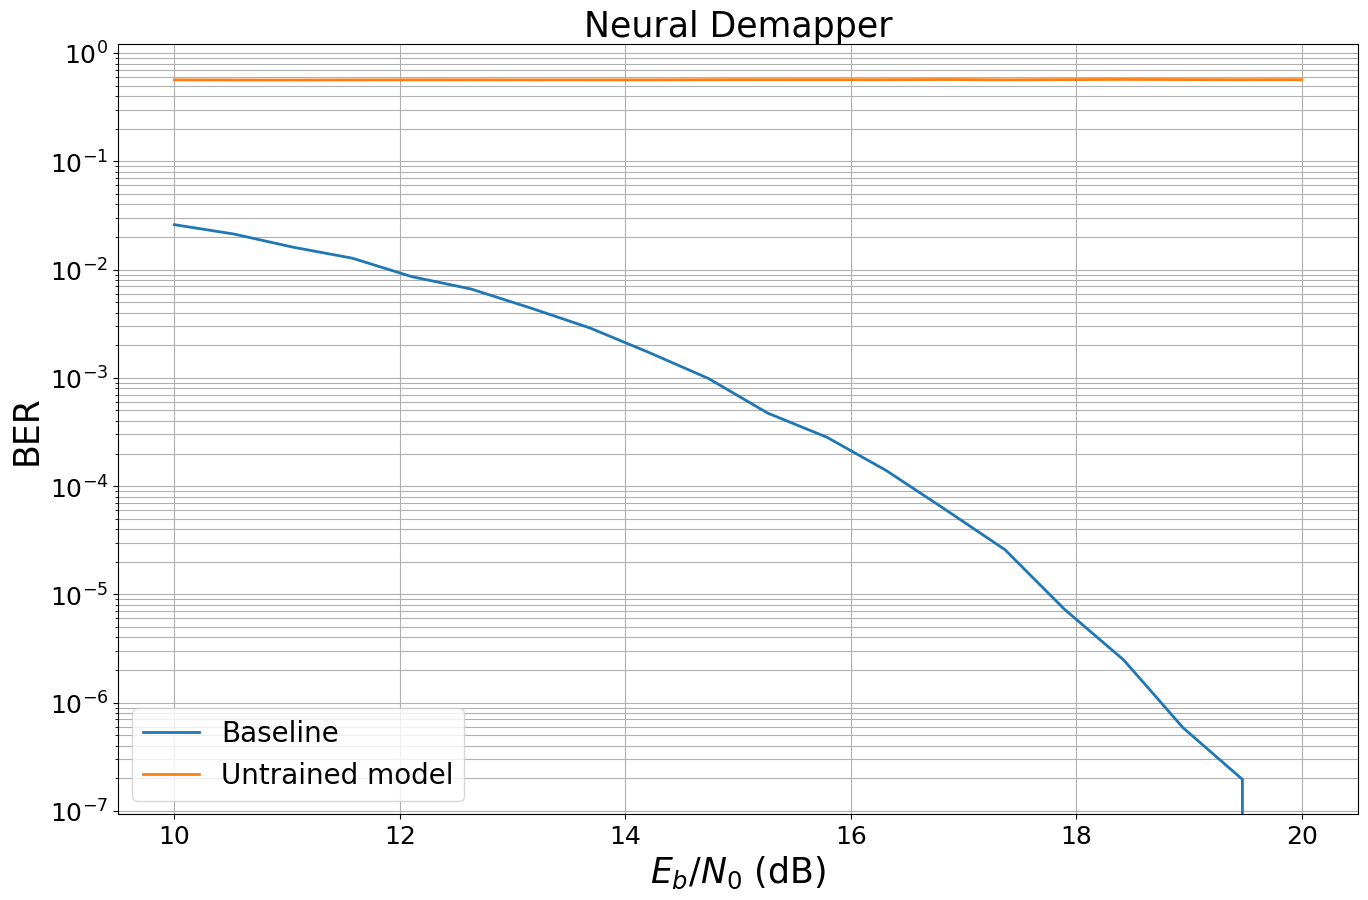

In [14]:
EBN0_DB_MIN = 10.0
EBN0_DB_MAX = 20.0


###############################
# Baseline
###############################

class Baseline(Model): # Inherits from Keras Model

    def __init__(self):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

###############################
# Benchmarking
###############################

baseline = Baseline()
model = End2EndSystem(False)
ber_plots = sn.utils.PlotBER("Neural Demapper")
ber_plots.simulate(baseline,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Baseline",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Untrained model",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

## Setting up Training Loops <a class="anchor" id="Setting-up-Training-Loops"></a>

Training of end-to-end communication systems consists in iterating over SGD steps.

The next cell implements a training loop of `NUM_TRAINING_ITERATIONS` iterations.
The training SNR is set to $E_b/N_0 = 15$ dB.

At each iteration:
- A forward pass through the end-to-end system is performed within a gradient tape
- The gradients are computed using the gradient tape, and applied using the Adam optimizer
- The estimated loss is periodically printed to follow the progress of training

In [15]:
# Number of iterations used for training
NUM_TRAINING_ITERATIONS = 30000

# Set a seed for reproducibility
tf.random.set_seed(1)

# Instantiating the end-to-end model for training
model_train = End2EndSystem(training=True)

# Adam optimizer (SGD variant)
optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(NUM_TRAINING_ITERATIONS):
    # Forward pass
    with tf.GradientTape() as tape:
        loss = model_train(BATCH_SIZE, 15.0) # The model is assumed to return the BMD rate
    # Computing and applying gradients
    grads = tape.gradient(loss, model_train.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_train.trainable_weights))
    # Print progress
    if i % 100 == 0:
        print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}", end="\r")

The weights of the trained model are saved using [pickle](https://docs.python.org/3/library/pickle.html).

In [16]:
# Save the weightsin a file
weights = model_train.get_weights()
with open('weights-neural-demapper', 'wb') as f:
    pickle.dump(weights, f)

Finally, we evaluate the trained model and benchmark it against the previously introduced baseline.

We first instantiate the model for evaluation and load the saved weights.

In [17]:
# Instantiating the end-to-end model for evaluation
model = End2EndSystem(training=False)
# Run one inference to build the layers and loading the weights
model(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-neural-demapper', 'rb') as f:
    weights = pickle.load(f)
    model.set_weights(weights)

The trained model is then evaluated.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.5241e-02 | 1.0000e+00 |        3877 |      153600 |          128 |         128 |         0.5 |reached target block errors
   10.526 | 1.9896e-02 | 1.0000e+00 |        3056 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.053 | 1.5124e-02 | 1.0000e+00 |        2323 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.579 | 1.1712e-02 | 1.0000e+00 |        1799 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.105 | 8.4440e-03 | 1.0000e+00 |        1297 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.632 | 6.3411e-03 | 1.0000e+00 |         974 |      153600 |

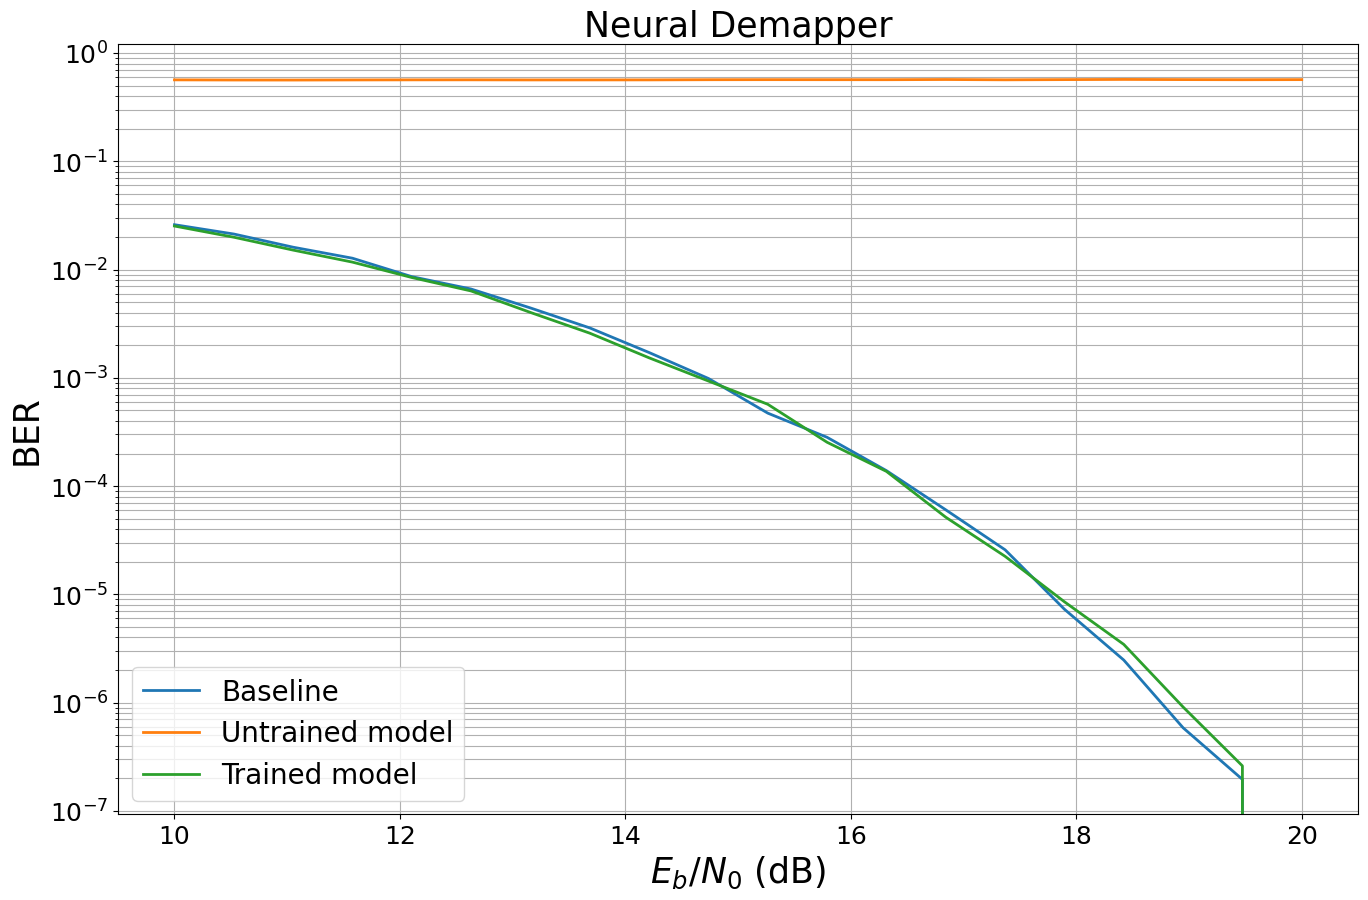

In [18]:
# Computing and plotting BER
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="Trained model",
                  soft_estimates=True,
                  max_mc_iter=100,
                  show_fig=True);